In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Laad gecategoriseerde data
df_full = pd.read_csv('../data/processed/transactions_categorized.csv')
df_full['Date'] = pd.to_datetime(df_full['Date'])

# Filter OUT saving, transfer, ATM (geen echte anomalies)
df = df_full[~df_full['Final_Category'].isin(['saving'])].copy()

print("="*60)
print("DATA LOADED FOR ANOMALY DETECTION")
print("="*60)
print(f"Original transactions: {len(df_full)}")
print(f"After filtering (no saving/transfer/atm): {len(df)}")
print(f"Excluded: {len(df_full) - len(df)} transactions")
print(f"\nDate range: {df['Date'].min().date()} to {df['Date'].max().date()}")

DATA LOADED FOR ANOMALY DETECTION
Original transactions: 1631
After filtering (no saving/transfer/atm): 1505
Excluded: 126 transactions

Date range: 2024-12-08 to 2025-12-08


In [2]:
print("="*60)
print("PREPARING FEATURES FOR ANOMALY DETECTION")
print("="*60)

# Maak absolute amount
df['Amount_Abs'] = df['Amount'].abs()

# Extract time features
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['DayOfMonth'] = pd.to_datetime(df['Date']).dt.day

# Category encoding (numeriek maken)
category_mapping = {cat: idx for idx, cat in enumerate(df['Final_Category'].unique())}
df['Category_Encoded'] = df['Final_Category'].map(category_mapping)

print(f"✅ Features prepared!")
print(f"\nFeatures for anomaly detection:")
print(f"  - Amount_Abs (absolute transaction amount)")
print(f"  - DayOfWeek (0=Monday, 6=Sunday)")
print(f"  - DayOfMonth (1-31)")
print(f"  - Category_Encoded (numerical category)")

# Show statistics
print("\n" + "="*60)
print("AMOUNT STATISTICS")
print("="*60)
print(df['Amount_Abs'].describe())

PREPARING FEATURES FOR ANOMALY DETECTION
✅ Features prepared!

Features for anomaly detection:
  - Amount_Abs (absolute transaction amount)
  - DayOfWeek (0=Monday, 6=Sunday)
  - DayOfMonth (1-31)
  - Category_Encoded (numerical category)

AMOUNT STATISTICS
count    1505.000000
mean       39.443767
std       103.840740
min         0.180000
25%         5.290000
50%        12.210000
75%        28.540000
max      1366.050000
Name: Amount_Abs, dtype: float64


In [3]:
print("="*60)
print("METHOD 1: STATISTICAL ANOMALY DETECTION")
print("="*60)

# Method 1: Z-score based detection
# Transacties die > 3 standard deviations van gemiddelde zijn

mean_amount = df['Amount_Abs'].mean()
std_amount = df['Amount_Abs'].std()

# Z-score berekenen
df['Z_Score'] = (df['Amount_Abs'] - mean_amount) / std_amount

# Anomalies = |Z-score| > 3
df['Is_Anomaly_Statistical'] = (df['Z_Score'].abs() > 3).astype(int)

anomalies_statistical = df[df['Is_Anomaly_Statistical'] == 1]

print(f"Mean amount: €{mean_amount:.2f}")
print(f"Std deviation: €{std_amount:.2f}")
print(f"Threshold (3 std): €{mean_amount + 3*std_amount:.2f}")

print(f"\n✅ Statistical anomalies found: {len(anomalies_statistical)} ({len(anomalies_statistical)/len(df)*100:.2f}%)")

if len(anomalies_statistical) > 0:
    print("\nTop 10 statistical anomalies:")
    top_anomalies = anomalies_statistical.nlargest(10, 'Amount_Abs')[
        ['Date', 'Amount', 'Amount_Abs', 'Counterparty', 'Final_Category', 'Z_Score']
    ]
    for idx, row in top_anomalies.iterrows():
        print(f"\n€{row['Amount']:8.2f} | {row['Final_Category'].ljust(15)} | {row['Counterparty'][:40]}")
        print(f"  Z-score: {row['Z_Score']:.2f} | Date: {row['Date'].date()}")

METHOD 1: STATISTICAL ANOMALY DETECTION
Mean amount: €39.44
Std deviation: €103.84
Threshold (3 std): €350.97

✅ Statistical anomalies found: 40 (2.66%)

Top 10 statistical anomalies:

€ 1366.05 | salary          | M&L Italian B.V.
  Z-score: 12.78 | Date: 2025-10-13

€ 1224.57 | salary          | M&L Italian B.V.
  Z-score: 11.41 | Date: 2025-08-12

€ 1160.54 | salary          | M&L Italian B.V.
  Z-score: 10.80 | Date: 2025-07-07

€ 1084.00 | transport       | BELASTINGDIENST
  Z-score: 10.06 | Date: 2025-05-12

€ 1047.12 | salary          | M&L Italian B.V.
  Z-score: 9.70 | Date: 2025-09-11

€  891.57 | salary          | M&L Italian B.V.
  Z-score: 8.21 | Date: 2025-06-12

€  869.99 | salary          | M&L Italian B.V.
  Z-score: 8.00 | Date: 2025-11-10

€  752.65 | salary          | M&L Italian B.V.
  Z-score: 6.87 | Date: 2025-01-13

€  689.16 | salary          | M&L Italian B.V.
  Z-score: 6.26 | Date: 2025-05-12

€  552.06 | transport       | AAB INZ TIKKIE
  Z-score: 4.94 | Da

In [4]:
print("="*60)
print("METHOD 2: ML-BASED ANOMALY DETECTION (ISOLATION FOREST)")
print("="*60)

# Selecteer features voor ML model
features_for_anomaly = ['Amount_Abs', 'DayOfWeek', 'DayOfMonth', 'Category_Encoded']

# Check for missing values
X_anomaly = df[features_for_anomaly].fillna(0)

print(f"Features used: {features_for_anomaly}")
print(f"Shape: {X_anomaly.shape}")

# Standardize features (belangrijk voor Isolation Forest)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_anomaly)

# Train Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Verwacht 5% anomalies
    random_state=42,
    n_estimators=100
)

print("\nTraining Isolation Forest model...")
df['Anomaly_Score'] = iso_forest.fit_predict(X_scaled)
df['Anomaly_Score_Value'] = iso_forest.score_samples(X_scaled)

# -1 = anomaly, 1 = normal
df['Is_Anomaly_ML'] = (df['Anomaly_Score'] == -1).astype(int)

anomalies_ml = df[df['Is_Anomaly_ML'] == 1]

print(f"\n✅ Isolation Forest training complete!")
print(f"ML anomalies detected: {len(anomalies_ml)} ({len(anomalies_ml)/len(df)*100:.2f}%)")

if len(anomalies_ml) > 0:
    print("\nTop 10 ML-detected anomalies:")
    top_ml_anomalies = anomalies_ml.nlargest(10, 'Amount_Abs')[
        ['Date', 'Amount', 'Amount_Abs', 'Counterparty', 'Final_Category', 'Anomaly_Score_Value']
    ]
    for idx, row in top_ml_anomalies.iterrows():
        print(f"\n€{row['Amount']:8.2f} | {row['Final_Category'].ljust(15)} | {row['Counterparty'][:40]}")
        print(f"  Anomaly score: {row['Anomaly_Score_Value']:.3f} | Date: {row['Date'].date()}")

METHOD 2: ML-BASED ANOMALY DETECTION (ISOLATION FOREST)
Features used: ['Amount_Abs', 'DayOfWeek', 'DayOfMonth', 'Category_Encoded']
Shape: (1505, 4)

Training Isolation Forest model...

✅ Isolation Forest training complete!
ML anomalies detected: 76 (5.05%)

Top 10 ML-detected anomalies:

€ 1366.05 | salary          | M&L Italian B.V.
  Anomaly score: -0.696 | Date: 2025-10-13

€ 1224.57 | salary          | M&L Italian B.V.
  Anomaly score: -0.685 | Date: 2025-08-12

€ 1160.54 | salary          | M&L Italian B.V.
  Anomaly score: -0.711 | Date: 2025-07-07

€ 1084.00 | transport       | BELASTINGDIENST
  Anomaly score: -0.698 | Date: 2025-05-12

€ 1047.12 | salary          | M&L Italian B.V.
  Anomaly score: -0.680 | Date: 2025-09-11

€  891.57 | salary          | M&L Italian B.V.
  Anomaly score: -0.651 | Date: 2025-06-12

€  869.99 | salary          | M&L Italian B.V.
  Anomaly score: -0.669 | Date: 2025-11-10

€  752.65 | salary          | M&L Italian B.V.
  Anomaly score: -0.658 | 

In [5]:
print("="*60)
print("COMBINING BOTH ANOMALY DETECTION METHODS")
print("="*60)

# Transacties die door BEIDE methodes als anomaly worden gedetecteerd
df['Is_Anomaly_Both'] = ((df['Is_Anomaly_Statistical'] == 1) & 
                          (df['Is_Anomaly_ML'] == 1)).astype(int)

anomalies_both = df[df['Is_Anomaly_Both'] == 1]

# Transacties die door MINSTENS 1 methode als anomaly worden gedetecteerd
df['Is_Anomaly_Either'] = ((df['Is_Anomaly_Statistical'] == 1) | 
                            (df['Is_Anomaly_ML'] == 1)).astype(int)

anomalies_either = df[df['Is_Anomaly_Either'] == 1]

print(f"Statistical method:        {df['Is_Anomaly_Statistical'].sum()} anomalies")
print(f"ML method (Iso Forest):    {df['Is_Anomaly_ML'].sum()} anomalies")
print(f"Both methods agree:        {df['Is_Anomaly_Both'].sum()} anomalies")
print(f"At least one method:       {df['Is_Anomaly_Either'].sum()} anomalies")

# High-confidence anomalies (detected by both)
if len(anomalies_both) > 0:
    print("\n" + "="*60)
    print("HIGH-CONFIDENCE ANOMALIES (detected by both methods)")
    print("="*60)
    
    high_conf_anomalies = anomalies_both.nlargest(10, 'Amount_Abs')[
        ['Date', 'Amount', 'Counterparty', 'Final_Category', 'Z_Score']
    ]
    
    for idx, row in high_conf_anomalies.iterrows():
        print(f"\n⚠️  €{row['Amount']:8.2f} | {row['Final_Category'].ljust(15)}")
        print(f"    {row['Counterparty'][:50]}")
        print(f"    Date: {row['Date'].date()} | Z-score: {row['Z_Score']:.2f}")

COMBINING BOTH ANOMALY DETECTION METHODS
Statistical method:        40 anomalies
ML method (Iso Forest):    76 anomalies
Both methods agree:        40 anomalies
At least one method:       76 anomalies

HIGH-CONFIDENCE ANOMALIES (detected by both methods)

⚠️  € 1366.05 | salary         
    M&L Italian B.V.
    Date: 2025-10-13 | Z-score: 12.78

⚠️  € 1224.57 | salary         
    M&L Italian B.V.
    Date: 2025-08-12 | Z-score: 11.41

⚠️  € 1160.54 | salary         
    M&L Italian B.V.
    Date: 2025-07-07 | Z-score: 10.80

⚠️  € 1084.00 | transport      
    BELASTINGDIENST
    Date: 2025-05-12 | Z-score: 10.06

⚠️  € 1047.12 | salary         
    M&L Italian B.V.
    Date: 2025-09-11 | Z-score: 9.70

⚠️  €  891.57 | salary         
    M&L Italian B.V.
    Date: 2025-06-12 | Z-score: 8.21

⚠️  €  869.99 | salary         
    M&L Italian B.V.
    Date: 2025-11-10 | Z-score: 8.00

⚠️  €  752.65 | salary         
    M&L Italian B.V.
    Date: 2025-01-13 | Z-score: 6.87

⚠️  €  689.16

In [6]:
print("="*60)
print("CATEGORY-SPECIFIC ANOMALY DETECTION")
print("="*60)

# Detect anomalies WITHIN each category
# Een €50 supermarket transactie is normaal, maar €500 is abnormaal

category_anomalies = []

for category in df['Final_Category'].unique():
    cat_data = df[df['Final_Category'] == category].copy()
    
    if len(cat_data) < 5:  # Skip categories met te weinig data
        continue
    
    # Bereken category-specific statistics
    cat_mean = cat_data['Amount_Abs'].mean()
    cat_std = cat_data['Amount_Abs'].std()
    
    if cat_std == 0:  # Alle bedragen zijn hetzelfde
        continue
    
    # Z-score binnen categorie
    cat_data['Cat_Z_Score'] = (cat_data['Amount_Abs'] - cat_mean) / cat_std
    
    # Anomalies = |Z-score| > 2.5 (iets lager dan global)
    cat_anomalies = cat_data[cat_data['Cat_Z_Score'].abs() > 2.5]
    
    if len(cat_anomalies) > 0:
        category_anomalies.append({
            'category': category,
            'count': len(cat_anomalies),
            'avg_amount': cat_mean,
            'examples': cat_anomalies.nlargest(3, 'Amount_Abs')
        })

print(f"Categories with anomalies: {len(category_anomalies)}")

print("\n" + "="*60)
print("TOP CATEGORY-SPECIFIC ANOMALIES")
print("="*60)

for cat_info in sorted(category_anomalies, key=lambda x: x['count'], reverse=True)[:5]:
    print(f"\n📊 {cat_info['category'].upper()} (avg: €{cat_info['avg_amount']:.2f})")
    print(f"   Anomalies found: {cat_info['count']}")
    print("   Unusual transactions:")
    
    for idx, row in cat_info['examples'].iterrows():
        print(f"     €{row['Amount_Abs']:7.2f} on {row['Date'].date()} - {row['Counterparty'][:35]}")

CATEGORY-SPECIFIC ANOMALY DETECTION
Categories with anomalies: 12

TOP CATEGORY-SPECIFIC ANOMALIES

📊 SUPERMARKET (avg: €10.44)
   Anomalies found: 8
   Unusual transactions:
     € 130.80 on 2025-08-18 - Frisdrank Voordeelshop
     € 101.80 on 2025-06-21 - Jumbo Breda Struyck
     €  96.36 on 2025-08-09 - Albert Heijn 1160

📊 BAR_CAFE (avg: €19.94)
   Anomalies found: 5
   Unusual transactions:
     € 255.00 on 2025-04-22 - Snel via Tikkie
     € 146.50 on 2025-11-29 - RAP*Hertog Jan Arcen
     € 144.00 on 2025-06-14 - Par-T B.V.

📊 GAMBLING (avg: €13.30)
   Anomalies found: 5
   Unusual transactions:
     € 100.00 on 2025-11-04 - 711 via Trustly Group AB
     € 100.00 on 2025-11-04 - 711 via Trustly Group AB
     €  78.95 on 2025-08-26 - Drie Gezusters Groning

📊 RESTAURANT (avg: €17.05)
   Anomalies found: 5
   Unusual transactions:
     € 156.70 on 2025-06-30 - CCV*Floryn Grand Cafe
     € 140.00 on 2025-07-25 - CAFE GIJ & IK
     € 108.40 on 2025-08-10 - Csalt Grill Steakhou

📊 ON

CREATING ANOMALY VISUALIZATIONS

✅ Visualization saved: visualizations/08_anomaly_detection.png


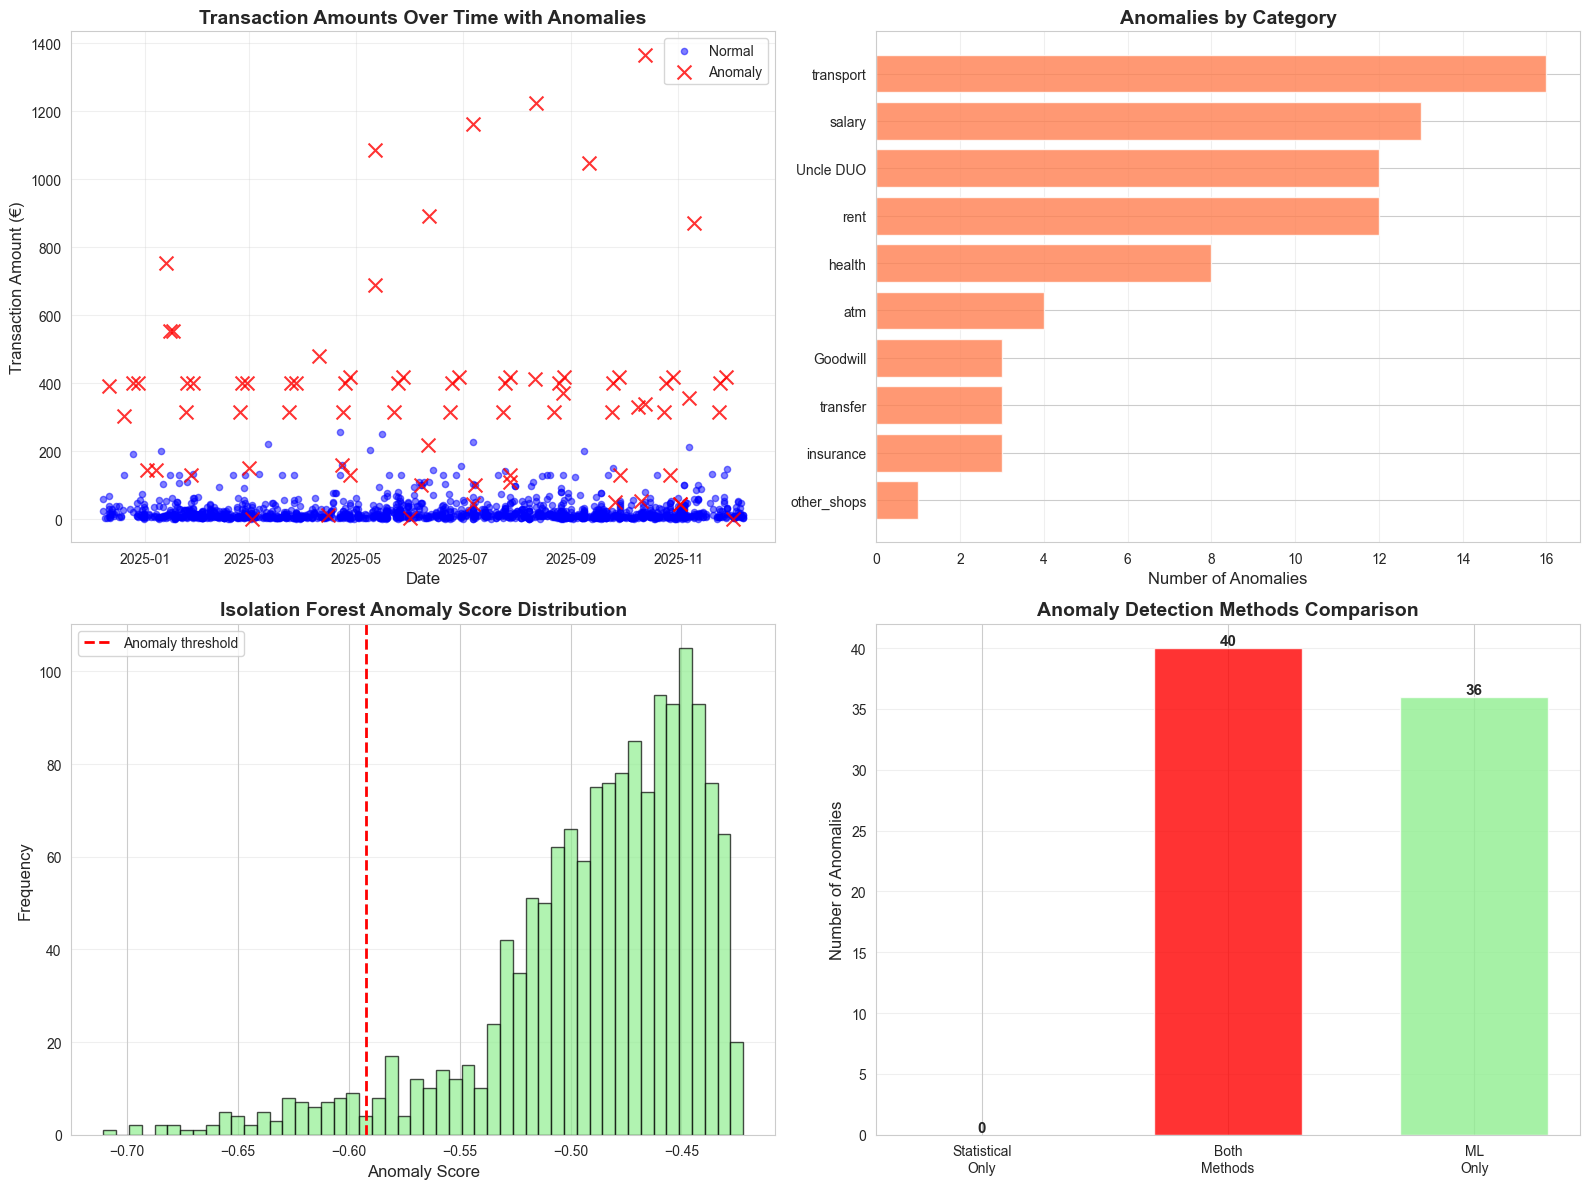

In [7]:
print("="*60)
print("CREATING ANOMALY VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Scatter plot - Amount vs Date met anomalies highlighted
axes[0, 0].scatter(df[df['Is_Anomaly_Either'] == 0]['Date'], 
                   df[df['Is_Anomaly_Either'] == 0]['Amount_Abs'],
                   alpha=0.5, s=20, color='blue', label='Normal')
axes[0, 0].scatter(df[df['Is_Anomaly_Either'] == 1]['Date'], 
                   df[df['Is_Anomaly_Either'] == 1]['Amount_Abs'],
                   alpha=0.8, s=100, color='red', marker='x', label='Anomaly')
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Transaction Amount (€)', fontsize=12)
axes[0, 0].set_title('Transaction Amounts Over Time with Anomalies', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Anomaly distribution by category
anomaly_by_cat = df[df['Is_Anomaly_Either'] == 1]['Final_Category'].value_counts().head(10)
axes[0, 1].barh(range(len(anomaly_by_cat)), anomaly_by_cat.values, color='coral', alpha=0.8)
axes[0, 1].set_yticks(range(len(anomaly_by_cat)))
axes[0, 1].set_yticklabels(anomaly_by_cat.index)
axes[0, 1].set_xlabel('Number of Anomalies', fontsize=12)
axes[0, 1].set_title('Anomalies by Category', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Plot 3: Anomaly score distribution (Isolation Forest)
axes[1, 0].hist(df['Anomaly_Score_Value'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=df[df['Is_Anomaly_ML'] == 1]['Anomaly_Score_Value'].max(), 
                   color='red', linestyle='--', linewidth=2, label='Anomaly threshold')
axes[1, 0].set_xlabel('Anomaly Score', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Isolation Forest Anomaly Score Distribution', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Venn diagram-style comparison
methods_comparison = pd.DataFrame({
    'Method': ['Statistical\nOnly', 'Both\nMethods', 'ML\nOnly'],
    'Count': [
        (df['Is_Anomaly_Statistical'] == 1).sum() - (df['Is_Anomaly_Both'] == 1).sum(),
        (df['Is_Anomaly_Both'] == 1).sum(),
        (df['Is_Anomaly_ML'] == 1).sum() - (df['Is_Anomaly_Both'] == 1).sum()
    ]
})

colors_methods = ['skyblue', 'red', 'lightgreen']
bars = axes[1, 1].bar(methods_comparison['Method'], methods_comparison['Count'], 
                      color=colors_methods, alpha=0.8, width=0.6)
axes[1, 1].set_ylabel('Number of Anomalies', fontsize=12)
axes[1, 1].set_title('Anomaly Detection Methods Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../visualizations/08_anomaly_detection.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved: visualizations/08_anomaly_detection.png")
plt.show()

In [8]:
print("="*60)
print("SAVING ANOMALY DETECTION RESULTS")
print("="*60)

# Save dataset met anomaly flags
df.to_csv('../data/processed/transactions_with_anomalies.csv', index=False)

print(f"✅ Full dataset with anomaly flags saved!")
print(f"   Location: data/processed/transactions_with_anomalies.csv")

# Save only anomalies voor snelle review
anomalies_only = df[df['Is_Anomaly_Either'] == 1][[
    'Date', 'Amount', 'Amount_Abs', 'Counterparty', 'Final_Category',
    'Is_Anomaly_Statistical', 'Is_Anomaly_ML', 'Z_Score', 'Anomaly_Score_Value'
]].sort_values('Amount_Abs', ascending=False)

anomalies_only.to_csv('../data/processed/detected_anomalies.csv', index=False)

print(f"✅ Anomalies-only file saved!")
print(f"   Location: data/processed/detected_anomalies.csv")
print(f"   Count: {len(anomalies_only)} anomalies")

print("\n" + "="*60)
print("📊 STEP 7 SUMMARY")
print("="*60)
print(f"✅ Statistical anomalies:      {df['Is_Anomaly_Statistical'].sum()}")
print(f"✅ ML anomalies (Iso Forest):  {df['Is_Anomaly_ML'].sum()}")
print(f"✅ High-confidence (both):     {df['Is_Anomaly_Both'].sum()}")
print(f"✅ Total flagged:              {df['Is_Anomaly_Either'].sum()} ({df['Is_Anomaly_Either'].mean()*100:.1f}%)")

print("\n🎉 STEP 7 COMPLETE!")

SAVING ANOMALY DETECTION RESULTS
✅ Full dataset with anomaly flags saved!
   Location: data/processed/transactions_with_anomalies.csv
✅ Anomalies-only file saved!
   Location: data/processed/detected_anomalies.csv
   Count: 76 anomalies

📊 STEP 7 SUMMARY
✅ Statistical anomalies:      40
✅ ML anomalies (Iso Forest):  76
✅ High-confidence (both):     40
✅ Total flagged:              76 (5.0%)

🎉 STEP 7 COMPLETE!
